In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

In [10]:
# Carregar os datasets
mitbih_train = pd.read_csv('dataset/mitbih_train.csv', header=None)
mitbih_test = pd.read_csv('dataset/mitbih_test.csv', header=None)

In [11]:
# Convertendo para o tipo de dados 'Int', que suporta NaN
mitbih_train[187] = mitbih_train[187].astype('Int64')
equilibre = mitbih_train[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: Int64


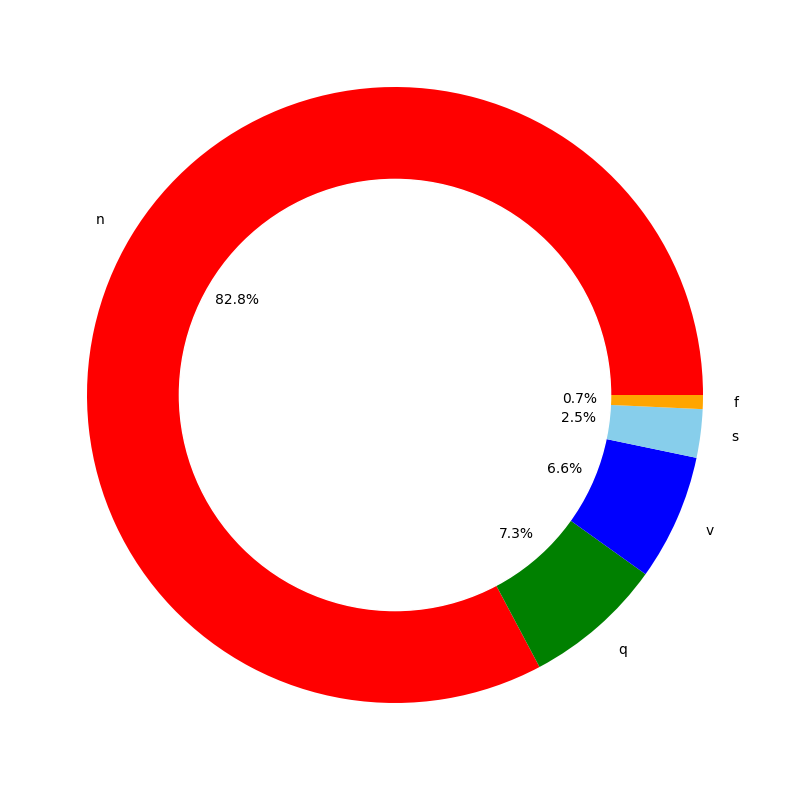

In [12]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Construção do modelo CNN

Para a construção da nossa Rede Neural Convolucional

In [24]:
from keras.utils import to_categorical

# Carregar o dataset
train_df = pd.read_csv('dataset/mitbih_train.csv', header=None)
test_df = pd.read_csv('dataset/mitbih_test.csv', header=None)

# Separação em características (X) e etiqueta (y)
X_train = train_df.iloc[:, :-1].values  # todas as colunas exceto a última
y_train = train_df.iloc[:, -1].values   # apenas a última coluna

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Imports 

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Lambda, Conv1D, BatchNormalization, ReLU, Add, MaxPooling1D, Dropout, Dense, GlobalAveragePooling1D, Softmax
from tensorflow.keras.models import Model

In [22]:
from tensorflow.keras.layers import Conv1D, Add, BatchNormalization, ReLU, Input, GlobalAveragePooling1D, Dense, Flatten
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=16, stride=1):
    # Caminho principal
    shortcut = x  # salva a entrada para a conexão residual
    
    # Primeira subcamada
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    
    # Segunda subcamada
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    
    # Conexão residual
    if x.shape[-1] != shortcut.shape[-1] or stride != 1:
        # Ajusta a dimensão do canal e tamanho se stride > 1
        shortcut = Conv1D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    
    x = Add()([x, shortcut])
    return x

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=7, strides=1, padding='same', use_bias=False)(inputs)  # Ajuste inicial para evitar dimensão desigual
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Adicionar blocos residuais
    num_blocks = 4  # por exemplo, 4 blocos
    num_filters = 64
    for i in range(num_blocks):
        stride = 2 if i % 2 == 0 else 1  # Aplica stride a cada segundo bloco
        x = residual_block(x, num_filters, stride=stride)
        num_filters *= 2  # Dobra o número de filtros a cada bloco
    
    x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Exemplo de uso
model = build_model((187, 1), 5)  # Supondo 5 classes para a saída
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 187, 64)      448         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 187, 64)     256         ['conv1d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_20 (ReLU)                (None, 187, 64)      0           ['batch_normalization_20[0][0

In [25]:
# Treinamento do modelo
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
2737/2737 [==============================] - 5602s 2s/step - loss: 0.5543 - accuracy: 0.9188 - val_loss: 0.3576 - val_accuracy: 0.8604
Epoch 2/10
2737/2737 [==============================] - 4224s 2s/step - loss: 0.1475 - accuracy: 0.9602 - val_loss: 1.3916 - val_accuracy: 0.6184
Epoch 3/10
2737/2737 [==============================] - 3884s 1s/step - loss: 0.4378 - accuracy: 0.9439 - val_loss: 0.1250 - val_accuracy: 0.9670
Epoch 4/10
2737/2737 [==============================] - 3877s 1s/step - loss: 0.1165 - accuracy: 0.9693 - val_loss: 0.0999 - val_accuracy: 0.9740
Epoch 5/10
2737/2737 [==============================] - 3879s 1s/step - loss: 0.0997 - accuracy: 0.9733 - val_loss: 0.0875 - val_accuracy: 0.9749
Epoch 6/10
2737/2737 [==============================] - 3885s 1s/step - loss: 0.0828 - accuracy: 0.9771 - val_loss: 0.1692 - val_accuracy: 0.9456
Epoch 7/10
2737/2737 [==============================] - 3857s 1s/step - loss: 0.0736 - accuracy: 0.9795 - val_loss: 0.0726 -

In [18]:
class BlocoResidual(Layer):
    def __init__(self, filters, kernel_size=3, stride=1, **kwargs):
        super().__init__(**kwargs)
        self.stride = stride

        # Main pathway
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        self.conv1 = Conv1D(filters, kernel_size, strides=stride, padding='same', use_bias=False)

        self.bn2 = BatchNormalization()
        self.relu2 = ReLU()
        self.dropout = Dropout(0.5)  # Example dropout rate
        self.conv2 = Conv1D(filters, kernel_size, strides=1, padding='same', use_bias=False)

        # Shortcut pathway
        self.shortcut = self._build_shortcut(filters, kernel_size, stride)

    def _build_shortcut(self, filters, kernel_size, stride):
        if stride > 1:
            return MaxPooling1D(pool_size=stride, strides=stride, padding='same')
        else:
            return Lambda(lambda x: x)  # Identity map

    def call(self, inputs):
        # Shortcut pathway
        shortcut = self.shortcut(inputs)

        # Main pathway
        x = self.bn1(inputs)
        x = self.relu1(x)
        x = self.conv1(x)

        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.conv2(x)

        x = Add()([x, shortcut])
        x = ReLU()(x)
        return x

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'stride': self.stride
        })
        return config

def build_model(input_shape, num_classes, nBR, nSub):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    nSubLayers = nBR // nSub

    # Add Residual Blocks
    x = BlocoResidual(64, stride=1)(x)
    
    for i in range(2, nSubLayers+1):
        for k in range(0, nSub):
            x = BlocoResidual(filters=64*i, stride=2)(x)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Usage Example
model = build_model(input_shape=(187, 1), num_classes=5, nBR=10, nSub=4)
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ValueError: Exception encountered when calling layer "bloco_residual_6" (type BlocoResidual).

in user code:

    File "C:\Users\carlos23001\AppData\Local\Temp\ipykernel_33504\1952922568.py", line 39, in call  *
        x = Add()([x, shortcut])
    File "c:\venv\ilumpy\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\venv\ilumpy\lib\site-packages\keras\layers\merging\base_merge.py", line 74, in _compute_elemwise_op_output_shape
        raise ValueError(

    ValueError: Inputs have incompatible shapes. Received shapes (47, 128) and (47, 64)


Call arguments received by layer "bloco_residual_6" (type BlocoResidual):
  • inputs=tf.Tensor(shape=(None, 94, 64), dtype=float32)